#Introduce

This notebook is created for the case using to load the Dataset (DIV2k) with difference key, and preprocessing image:


1.   Load the dataset with key.
2.   Preprocessing image.
3.   Seperate the dataset.



In [9]:
print('import libary...')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
  

import libary...


In [17]:
def load_dataset(key='div2k',include_validate=True):
  print('using tensorflow_datasets to load the dataset','\nloading dataset...')
  if include_validate:
    (train_ds, val_ds), metadata = tfds.load(
    key,
    split=['train','validation'],
    with_info=True,
    as_supervised=True,
   )
  else:
    (train_ds, val_ds), metadata = tfds.load(
    key,
    split=['train'],
    with_info=True,
    as_supervised=True,
    )
  print(metadata)
  return (train_ds,val_ds),metadata

In [93]:
def normalize_img(image):
  print('Normalizes images: `uint8` -> `float32`')
  return tf.cast(image, tf.float32) /255

In [14]:
def configure_performan(ds,BUFFER_SIZE=1000,BATCH_SIZE=4):
  ds=ds.cache()
  ds=ds.shuffle(buffer_size=BUFFER_SIZE)
  ds=ds.batch(BATCH_SIZE)
  ds=ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [ ]:
(rain_ds,val_ds),infor=load_dataset('div2k/bicubic_x4')

In [24]:

len(rain_ds)

800

In [106]:
sub_data=rain_ds.take(40)

In [88]:
for i in sub_data.take(1):
  print(i[0].shape)
  print(i[1].shape)

(306, 510, 3)
(1224, 2040, 3)


In [89]:

def show(image, label):
  plt.figure(figsize=(len(image.numpy())/80,len(image.numpy()[0])/80))
  plt.imshow(image)
  plt.title(np.array(label))
  plt.axis('off')

In [ ]:
for i in sub_data.take(2):
    # print(len(i[0].numpy()))
  show(i[0],'Low resolution')
  show(i[1],'High resolution')

In [113]:
for i in sub_data.take(1):
  print(i[1].numpy())  

[[[0.22745098 0.27450982 0.01568628]
  [0.22745098 0.27058825 0.01568628]
  [0.23137255 0.25490198 0.01960784]
  ...
  [0.34509805 0.38039216 0.19215687]
  [0.3882353  0.43137255 0.2       ]
  [0.39215687 0.43137255 0.20784314]]

 [[0.22352941 0.25882354 0.00784314]
  [0.21176471 0.25490198 0.01568628]
  [0.22745098 0.26666668 0.03137255]
  ...
  [0.2509804  0.29411766 0.13725491]
  [0.36078432 0.4117647  0.2       ]
  [0.47843137 0.52156866 0.28235295]]

 [[0.21960784 0.25490198 0.00392157]
  [0.23529412 0.25882354 0.01176471]
  [0.3372549  0.3764706  0.10588235]
  ...
  [0.21568628 0.2627451  0.11372549]
  [0.39215687 0.44705883 0.23529412]
  [0.4745098  0.52156866 0.28627452]]

 ...

 [[0.30588236 0.23921569 0.12941177]
  [0.29411766 0.23921569 0.1254902 ]
  [0.30588236 0.24705882 0.13333334]
  ...
  [0.2784314  0.24705882 0.18039216]
  [0.4509804  0.36862746 0.21176471]
  [0.7019608  0.54509807 0.29803923]]

 [[0.28627452 0.22745098 0.11372549]
  [0.2784314  0.22352941 0.11764706]


In [108]:
sub_data=sub_data.map(lambda lr,hr: (normalize_img(lr) , normalize_img(hr)),num_parallel_calls=tf.data.AUTOTUNE)

Normalizes images: `uint8` -> `float32`
Normalizes images: `uint8` -> `float32`


In [109]:
len(sub_data)

40

In [169]:
def visualize(original, augmented,type='lr'):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image'+type)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image'+type)
  plt.imshow(augmented)

In [ ]:
arr=np.array([[1,2,3],[3,2,1]])

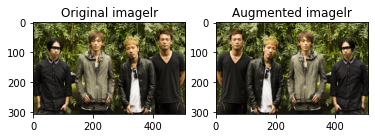

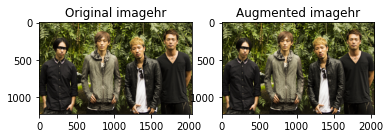

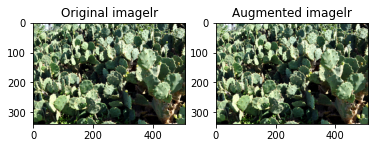

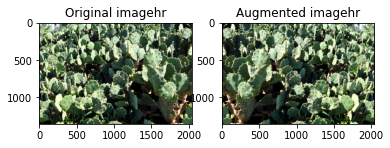

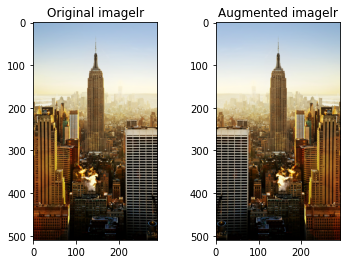

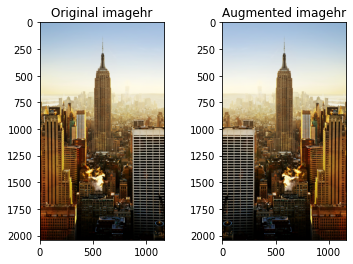

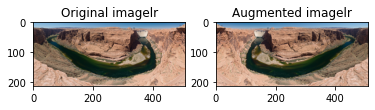

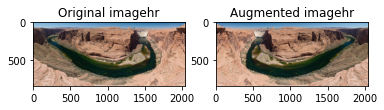

In [170]:
a=0
for i in sub_data.take(4):
  a=a+1
    # print(len(i[0].numpy()))
  au=tf.image.random_flip_left_right(i[0])
  visualize(i[0],au,'lr')
  au=tf.image.random_flip_left_right(i[1])
  visualize(i[1],au,type='hr')
  # show(i[1],'High resolution')


In [135]:
seed = (2, 3)

In [147]:
np.array([[2.2,3],[23,3]]).shape

(2, 2)